$\textbf{*** This version uses the }\texttt{Dataloader, Asset, Portfolio}\textbf{ classes to load data}$

In [1]:
import sys
import importlib
sys.path.append('../')

from src.finance_ml.data_preparation.data_preparation import DataLoader
from src.finance_ml.data_preparation.asset_class import Asset
from src.finance_ml.data_preparation.portfolio_class import Portfolio

from src.finance_ml.denoising.denoising import Denoising
from src.finance_ml.indicators.indicators import Indicators
from src.finance_ml.volatility.volatility import Volatility

In [2]:
# Import required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math

## Reading the Data File

In [3]:
# Defining time_index_col (must be the same column in all inputs) and keep_cols refering to the columns that will remain in the dataset
dataloader = DataLoader(time_index_col= 'DATE', 
                    keep_cols = ['VOLUME','OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW','TRANSACTIONS'])

In [4]:
# loading assets into to an unique df
df = dataloader.load_dataset({'AAPL':'../data/equities/AAPL_2020-04-07_2022-04-06.parquet'})
display(df)

,AAPL_VOLUME,AAPL_OPEN,AAPL_HIGHT,AAPL_LOW,AAPL_CLOSE,AAPL_VW,AAPL_TRANSACTIONS
DATE,,,,,,,
2020-04-07 12:17:00,14256.0,67.3500,67.3625,67.3275,67.3375,67.3454,45
2020-04-07 12:18:00,16552.0,67.3501,67.3625,67.3250,67.3250,67.3407,57
2020-04-07 12:19:00,80172.0,67.3250,67.4475,67.3250,67.4225,67.3937,149
2020-04-07 12:20:00,183740.0,67.4475,67.4700,67.3125,67.3700,67.3671,159
2020-04-07 12:21:00,35372.0,67.3500,67.3850,67.2975,67.2975,67.3469,102
...,...,...,...,...,...,...,...
2022-04-06 23:55:00,840.0,170.9800,170.9800,170.9300,170.9700,170.9593,26
2022-04-06 23:56:00,2816.0,170.9300,170.9500,170.8500,170.9500,170.8997,56
2022-04-06 23:57:00,311.0,170.9300,170.9400,170.9300,170.9400,170.9244,12


In [5]:
data_cols = ['DATE', 'OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW', 'VOLUME']

var_cols = ['OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW', 'VOLUME', 'CLOSE_returns', 
            'CLOSE_log_returns', 'CLOSE_price_change','CLOSE_pct_change', 
            'RA_5', 'RA_10', 'AMPL', 'OPNCLS', 'MA_5', 'MA_10','V_MA_5', 
            'V_MA_10', 'V_MA_20']

normvar_cols = ['N_OPEN', 'N_HIGHT', 'N_LOW', 'N_CLOSE', 'N_VW', 'N_VOLUME',
                'N_CLOSE_returns', 'N_CLOSE_log_returns', 'N_CLOSE_price_change',
                'N_CLOSE_pct_change', 'N_RA_5', 'N_RA_10', 'N_AMPL', 'N_OPNCLS', 
                'N_MA_5', 'N_MA_10','N_V_MA_5', 'N_V_MA_10', 'N_V_MA_20']

vol_cols = ['CorwinSchultz', 'HodgesTompkins', 'ZhangYang', 'RogersSatchell', 'GarmanKlaus']

In [6]:
var_cols = ['AAPL_'+col for col in var_cols]
normvar_cols = ['AAPL_'+col for col in normvar_cols]
vol_cols = ['AAPL_'+col for col in vol_cols]

# Data Augmentation

In order to increase the number of variables considered in the covariance matrix, this module introduced some sample $\textit{indicators}$ and $\textit{volatility}$ indexes calculated over the asset's data.

After $\textbf{Volatility}$ and $\textbf{Data Generation}$ groups introduced the appropriate classes, we can eliminate this portion of code and dependencies.

## Calculate Indicators

In [7]:
# Process data normalization
norm_data = True

# Select Indicator transformer
ind_processor = Indicators(df, ticker = 'AAPL', norm_data = norm_data)

# Calculate Indicators over input dataframe
df = ind_processor.transform(df)

# Display output dataframe
display(df[var_cols+normvar_cols if norm_data else var_cols])

,AAPL_OPEN,AAPL_HIGHT,AAPL_LOW,AAPL_CLOSE,AAPL_VW,AAPL_VOLUME,AAPL_CLOSE_returns,AAPL_CLOSE_log_returns,AAPL_CLOSE_price_change,AAPL_CLOSE_pct_change,...,AAPL_N_CLOSE_pct_change,AAPL_N_RA_5,AAPL_N_RA_10,AAPL_N_AMPL,AAPL_N_OPNCLS,AAPL_N_MA_5,AAPL_N_MA_10,AAPL_N_V_MA_5,AAPL_N_V_MA_10,AAPL_N_V_MA_20
DATE,,,,,,,,,,,,,,,,,,,,,
2020-04-07 12:17:00,67.3500,67.3625,67.3275,67.3375,67.3454,14256.0,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,-0.994012,-0.068627,-0.951309,-0.951750,-0.994354,-0.992676,-0.990184
2020-04-07 12:18:00,67.3501,67.3625,67.3250,67.3250,67.3407,16552.0,0.999814,-0.000186,-0.0125,-0.000186,...,-0.024123,NaN,NaN,-0.993584,-0.070980,-0.951414,-0.951855,-0.993895,-0.992077,-0.989377
2020-04-07 12:19:00,67.3250,67.4475,67.3250,67.4225,67.3937,80172.0,1.001448,0.001447,0.0975,0.001448,...,0.018143,NaN,NaN,-0.979042,-0.048086,-0.950903,-0.951344,-0.985262,-0.980799,-0.974195
2020-04-07 12:20:00,67.4475,67.4700,67.3125,67.3700,67.3671,183740.0,0.999221,-0.000779,-0.0525,-0.000779,...,-0.039464,NaN,NaN,-0.973054,-0.080766,-0.950868,-0.951309,-0.970591,-0.961636,-0.948396
2020-04-07 12:21:00,67.3500,67.3850,67.2975,67.2975,67.3469,35372.0,0.998924,-0.001077,-0.0725,-0.001076,...,-0.047160,-0.974896,NaN,-0.985030,-0.076097,-0.951090,-0.951532,-0.973655,-0.965638,-0.953784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06 23:55:00,170.9800,170.9800,170.9300,170.9700,170.9593,840.0,0.999883,-0.000117,-0.0200,-0.000117,...,-0.022347,-0.969242,-0.942920,-0.991446,-0.068161,0.792690,0.794215,-0.998939,-0.999005,-0.998517
2022-04-06 23:56:00,170.9300,170.9500,170.8500,170.9500,170.8997,2816.0,0.999883,-0.000117,-0.0200,-0.000117,...,-0.022347,-0.979185,-0.938289,-0.982891,-0.062558,0.792118,0.793795,-0.998846,-0.998903,-0.998448
2022-04-06 23:57:00,170.9300,170.9400,170.9300,170.9400,170.9244,311.0,0.999942,-0.000058,-0.0100,-0.000058,...,-0.020834,-0.977174,-0.938289,-0.998289,-0.064426,0.791849,0.793324,-0.999299,-0.998902,-0.998475


## Calculate Volatility Indicators

In [8]:
# Select Volatility transformer
vol_processor = Volatility(df, ticker = 'AAPL')

# Calculate Volatility over input dataframe
df = vol_processor.transform(df)

# Display output dataframe
display(df[vol_cols])

,AAPL_CorwinSchultz,AAPL_HodgesTompkins,AAPL_ZhangYang,AAPL_RogersSatchell,AAPL_GarmanKlaus
DATE,,,,,
2020-04-07 12:17:00,NaN,NaN,NaN,NaN,NaN
2020-04-07 12:18:00,0.000495,NaN,NaN,NaN,NaN
2020-04-07 12:19:00,0.000201,NaN,NaN,NaN,NaN
2020-04-07 12:20:00,0.001506,NaN,NaN,NaN,NaN
2020-04-07 12:21:00,0.000275,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-06 23:55:00,0.000000,0.005023,0.004920,0.049906,0.002751
2022-04-06 23:56:00,0.000000,0.005023,0.005153,0.055412,0.002994
2022-04-06 23:57:00,0.000007,0.005012,0.005165,0.055412,0.002994


## Data Preparation

In [9]:
X = np.array(df[normvar_cols+vol_cols if norm_data else var_cols+vol_cols])[30:]

## Denoising the Covariance Matrix

In [10]:
# Instanciate the Denoising transformer
denoise_processor = Denoising()

# Calculates Correlation, Covariance, EigenValues and EigenVectors of denoised covariance matrix
cov1, corr1, eVal1, eVec1 = denoise_processor.transform(X)

# Calculates non-denoised Covariance Matrix
cov0 = np.cov(X,rowvar=0)
corr0 = Denoising.cov2corr(cov0)

## Visualization or results

In [11]:
#----- Comparison between Non-Denoised and Denoised Cov Matrices
def plotHeatMaps (corr0, corr1, txt: str):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.subplots_adjust(wspace=1)

    sns.set(font_scale=0.6)

    sns.heatmap(corr0, cmap="plasma", ax=ax1, cbar=True)
    sns.heatmap(corr1, cmap="plasma", ax=ax2, cbar=True)

    # ax2.yaxis.tick_right()

    ax1.set_title('non-denoised', fontsize=12)
    ax2.set_title('denoised '+txt, fontsize=12)

    fig.subplots_adjust(wspace=0.001)
    plt.show()


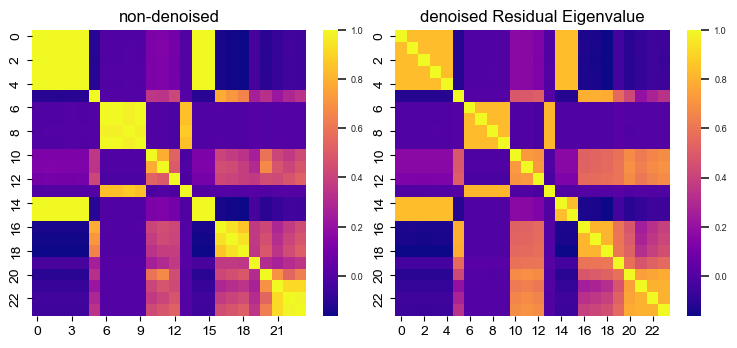

In [12]:
# Compare the correlation matrix before and after denoising
plotHeatMaps(corr0, corr1, 'Residual Eigenvalue')

# Calculate Marchenko-Pastur Density

The objective of the fit is to find the value of $\sigma^2$ that minimizes the sum of the squared differences between the analytical PDF and the kernel density estimate (KDE) of the observed eigenvalues.

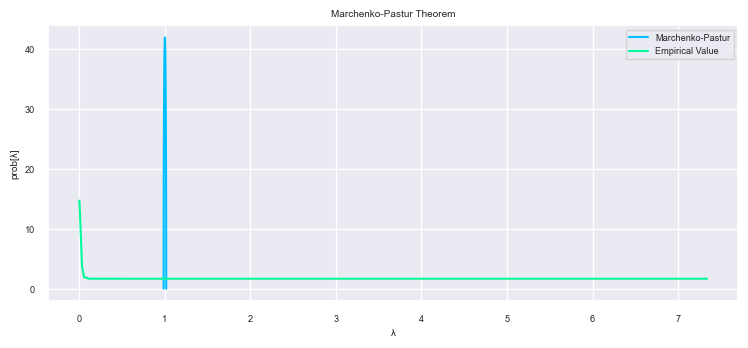

In [13]:
# Instanciate Marcenko Pastur processor
marcpastur_processor = Denoising(q=X.shape[0]/float(X.shape[1]))  #, pts=X.shape[1])

# Getting eigenvalues and eigenvectors
eVal0, eVec0 = marcpastur_processor.getPCA(corr0)

# Marchenko-Pastur pdf
pdf0 = marcpastur_processor.mpPDF(1.)

# Empirical pdf
pdf1= marcpastur_processor.fitKDE(np.diag(eVal0))

# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
# ax.set_yscale('log')
ax.legend(loc="upper right")

## Eigen Values compared with Marcenko Pastur distribution

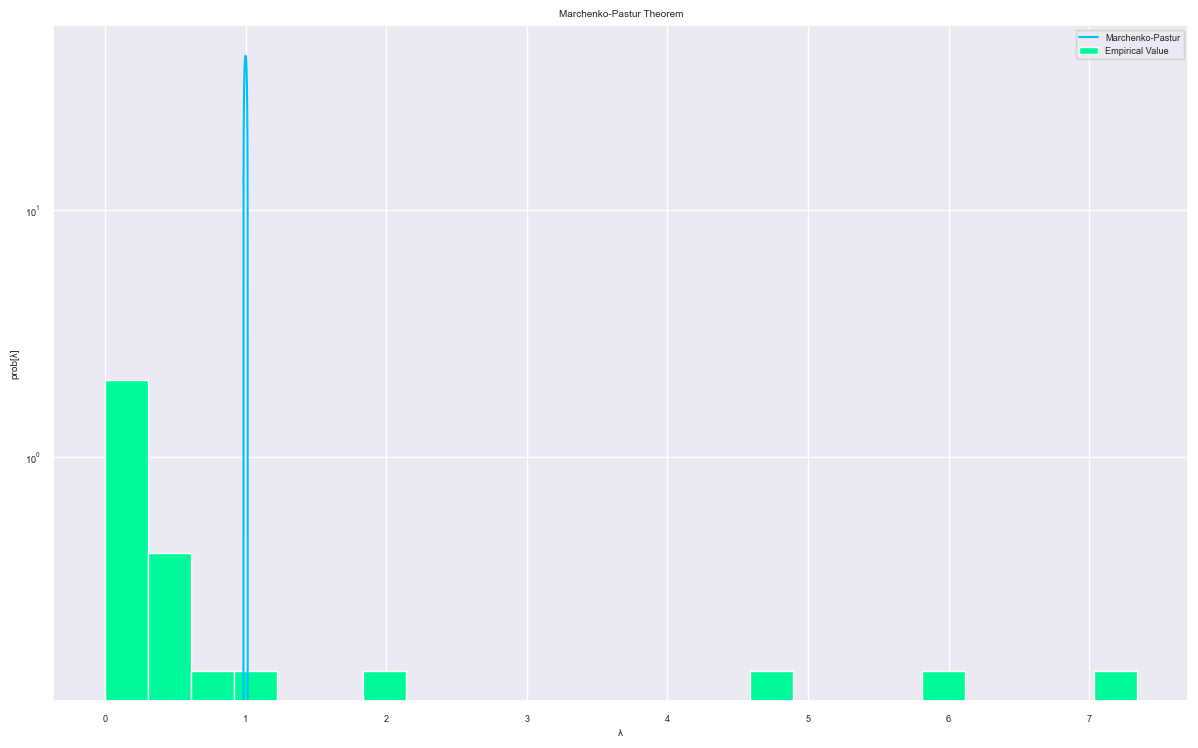

In [14]:
# Getting Eigenvalues and Eigenvectors
eVal0, eVec0 = marcpastur_processor.getPCA(corr0)

# Getting Max Eigenvalues and calculating variance attributed to noise
eMax0, var0 = marcpastur_processor.findMaxEval(np.diag(eVal0))
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

# Getting PDFs and plotting it
pdf0 = marcpastur_processor.mpPDF(var0)

# Plotting PDFs
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(12,7.5))
ax.hist(pd.Series(np.diag(eVal0)), density="norm", bins=X.shape[1], label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.set_yscale('log')
ax.legend(loc="upper right")

Eigenvalues to the right of the fitted Marcenko–Pastur distribution cannot be associated with noise, thus they are
related to signal.

In [15]:
print(f'Eigenvalues:\n{np.diag(eVal0)}')

Eigenvalues:
[ 7.33870561e+00  6.11010735e+00  4.73843631e+00  1.92657522e+00
  1.11640559e+00  8.20758857e-01  6.01279701e-01  3.58797814e-01
  3.25242215e-01  2.31084623e-01  1.97759530e-01  1.11482731e-01
  5.38410513e-02  3.22513962e-02  3.11384493e-02  6.07337541e-03
  2.70786734e-05  1.62888100e-05  1.24426169e-05  2.77744272e-06
  1.57946156e-06  5.01869793e-16  6.30396136e-17 -3.29943312e-15]


# Monte Carlo Simulation

Adapted from Chap. 2 of $\textit{Machine Learning for Asset Managers}$, by Marcos M. Lopez de Prado - 1st. edition


This block of code reproduces the example to compute the errors with estimating a minimum variance portfolio with and without noising.

## Generating Block Diagonal Matrix

I this block we generate a vector of means and a covariance matrix out of ten blocks of size fifty each, where offdiagonal
elements within each block have a correlation of 0.5. This covariance matrix is a stylized representation of a true (nonempirical) detoned correlation matrix of the $\textbf{S&P 500}$, where each block is associated with an economic sector. 

Variances are drawn from uniform distribution bounded $[.05, .2]$ and the means sampled from a Standard Normal distribution. This is consistent with the notion that in an efficient market all securities have the same expected Sharpe ratio.

In [16]:
from scipy.linalg import block_diag

# SNIPPET 2.7 GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS
def formBlockMatrix(nBlocks,bSize,bCorr): 
    block=np.ones((bSize,bSize))*bCorr 
    block[range(bSize),range(bSize)]=1 
    corr=block_diag(*([block]*nBlocks)) 
    return corr
#--------------------------------------------------- 
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr) 
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0=corr0[cols].loc[cols].copy(deep=True) 
    std0=np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0=Denoising.corr2cov(corr0,std0) 
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1) 
    return mu0,cov0

## Generating Empirical Covariance Matrix

Now, $\textbf{Lopez}$ uses the true (nonempirical) covariance matrix to draw a random matrix $\tilde{X}$ of size $T\times N$, and it derives the associated empirical covariance matrix and vector of means.

In [17]:
from sklearn.covariance import LedoitWolf

# SNIPPET 2.8 GENERATING THE EMPIRICAL COVARIANCE MATRIX
def simCovMu(mu0, cov0, nObs, shrink=False): 
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:
        cov1=LedoitWolf().fit(x).covariance_ 
    else:
        cov1=np.cov(x,rowvar=0)
    return mu1,cov1

### Denoising the Empirical Cov Matrix

Here, Lopez applies the denoising routine to denoise the empirical covariance matrix. In this particular experiment, we denoise through the $\textit{constant residual eigenvalue}$ method.

In [18]:
# SNIPPET 2.9 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
#--------------------------------------------------- 
def deNoiseCov(cov0,d_transf):
    corr0=Denoising.cov2corr(cov0)
    eVal0,eVec0=d_transf.getPCA(corr0) 
    eMax0,var0=d_transf.findMaxEval(np.diag(eVal0)) 
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0) 
    corr1=d_transf.denoisedCorr(eVal0,eVec0,nFacts0) 
    cov1=Denoising.corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

In [19]:
#----- Generating Block Diagonal Cov Matrix and Vector of Means
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [20]:
#----- Generating Empirical Cov Matrix
mu1, cov1 = simCovMu(mu0,cov0,1000,shrink=True)

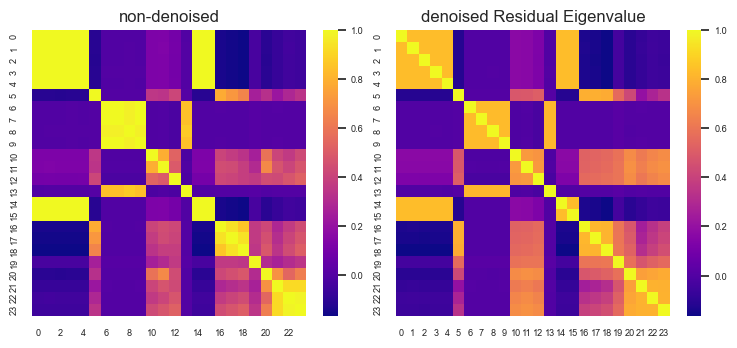

In [21]:
# Compare the correlation matrix before and after denoising
plotHeatMaps(corr0, corr1, 'Residual Eigenvalue')

### Simulation

This runs the following $\textit{Monte Carlo experiment}$ with $1,000$ iterations: (1) draw a random empirical covariance matrix (shrinkage optional) with $T=1,000$; (2) denoise the empirical covariance matrix (optional); (3) derive the minimum variance portfolio, using the function $\texttt{optPort}$. When we pass the argument shrink=True to function $\texttt{simCovMu}$, the covariance matrix is shrunk.

In [22]:
def optPort(cov,mu=None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0],1))
    if mu is None:
        mu = ones
    w = np.dot(inv,mu)
    w /= np.dot(ones.T,w)
    return w
#---------------------------------------------------
nObs,nTrials,bWidth,shrink,minVarPortf=1000,100,.01,False,True

mc_processor = Denoising(q=nObs*1./cov1.shape[1])

w1=pd.DataFrame(columns=range(cov0.shape[0]),
        index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf: 
        mu1=None
    cov1_d=deNoiseCov(cov1,mc_processor)
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

Following the simulation, Lopez computes the true minimum variance portfolio, derived from the true covariance matrix. Using those allocations as benchmark, it then computes the root-mean-square errors (RMSE) across all weights, with and
without denoising.

In [23]:
#----- Root Mean Errors
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(f"Total RSME:")
print("-----------\n")
print(f"Non-Denoised {rmsd*100:.4f}% | Denoised {rmsd_d*100:.4f}%")
print(f"Ratio: {rmsd_d/rmsd:.4f}")

Total RSME:
-----------

Non-Denoised 0.4993% | Denoised 0.1138%
Ratio: 0.2278
